# William Kiger - Kristopher Gallagher
Spring 2023 DLH 598 Final Project
RAPS Implemented as in https://arxiv.org/abs/2009.14193 
and https://github.com/aangelopoulos/conformal_classification

In [7]:
import os
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt 
import collections, itertools, json, os, pathlib, sys


#imports from Conforamal RAPS
from conformal_raps.conformal import *
from conformal_raps.utils import *

#PyTorch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

In [4]:
# Upload the model file
from google.colab import files
uploaded = files.upload()

Saving conformal_raps.zip to conformal_raps.zip
Saving my_utils.py to my_utils.py
Saving my_conformal.py to my_conformal.py
Saving validation_dataset.zip to validation_dataset.zip
Saving resnet_18_derm_model_test_v2.pt to resnet_18_derm_model_test_v2.pt


# Setting up our transforms for infernece

In [6]:
zip_file = 'conformal_raps.zip'

# Extract the contents of the ZIP file
import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

In [8]:
#setting seeds to 0 for reproducability
np.random.seed(seed=0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

In [9]:
cudnn.benchmark = True
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device = " + str(device))

Device = cuda:0


# Load our model

In [10]:
model_path = r"resnet_18_derm_model_test_v2.pt"
model = torch.load(model_path)
# model.to(device)
model = torch.nn.DataParallel(model)  # wdk...for multi-gpu instances
#model to eval mode
_ = model.eval()

# Get the conformal calibration and validation datasets

In [11]:
root = r'validation_dataset'
validate_path = os.path.join(root, 'val')

calibration_dataset, validation_dataset = torch.utils.data.random_split(
    torchvision.datasets.ImageFolder(validate_path, transform), [100, 890-100]) #[num, num_image-num]

calib_loader = torch.utils.data.DataLoader(
    calibration_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Conformalize the model - perform platt scaling and then wrap the model with RAPS

In [12]:
cmodel = ConformalModel(model, calib_loader, alpha=0.1, lamda_criterion='size')

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:08<00:00,  8.09s/it]

Optimal T=1.299961805343628


# Validate the coverage of the conformal model and validation sets.  Note that the running averages of coverage and size are in parenthesis.  

In [13]:
top1, top5, coverage, size = validate(val_loader, cmodel, print_bool=True)

N: 790 | Time: 0.392 (1.375) | Cvg@1: 0.636 (0.415) | Cvg@5: 0.955 (0.857) | Cvg@RAPS: 0.955 (0.889) | Size@RAPS: 5.545 (5.322)


# Now use RAPS 

In [14]:
#prefilling parameters
num_images = 890
num_calib = 100

class_names = {0: 'allergic_contact_dermatitis', 1: 'basal_cell_carcinoma', 2: 'folliculitis', 
               3: 'lichen_planus', 4: 'lupus_erythematosus', 5: 'neutrophilic_dermatoses', 
               6: 'photodermatoses', 7: 'psoriasis', 8: 'sarcoidosis', 9: 'squamous_cell_carcinoma'}
class_names = list(class_names.values())

Image 0 has label 'allergic_contact_dermatitis', and the predictive set is ['psoriasis', 'allergic_contact_dermatitis', 'sarcoidosis', 'lichen_planus', 'photodermatoses', 'lupus_erythematosus'].
Image 1 has label 'basal_cell_carcinoma', and the predictive set is ['neutrophilic_dermatoses', 'lichen_planus', 'psoriasis', 'squamous_cell_carcinoma', 'allergic_contact_dermatitis', 'lupus_erythematosus'].
Image 2 has label 'folliculitis', and the predictive set is ['lichen_planus', 'psoriasis', 'lupus_erythematosus'].
Image 3 has label 'lichen_planus', and the predictive set is ['lupus_erythematosus', 'sarcoidosis', 'photodermatoses', 'allergic_contact_dermatitis', 'squamous_cell_carcinoma', 'lichen_planus'].
Image 4 has label 'lupus_erythematosus', and the predictive set is ['psoriasis', 'lichen_planus', 'lupus_erythematosus', 'sarcoidosis', 'allergic_contact_dermatitis', 'squamous_cell_carcinoma'].
Image 5 has label 'neutrophilic_dermatoses', and the predictive set is ['sarcoidosis', 'alle

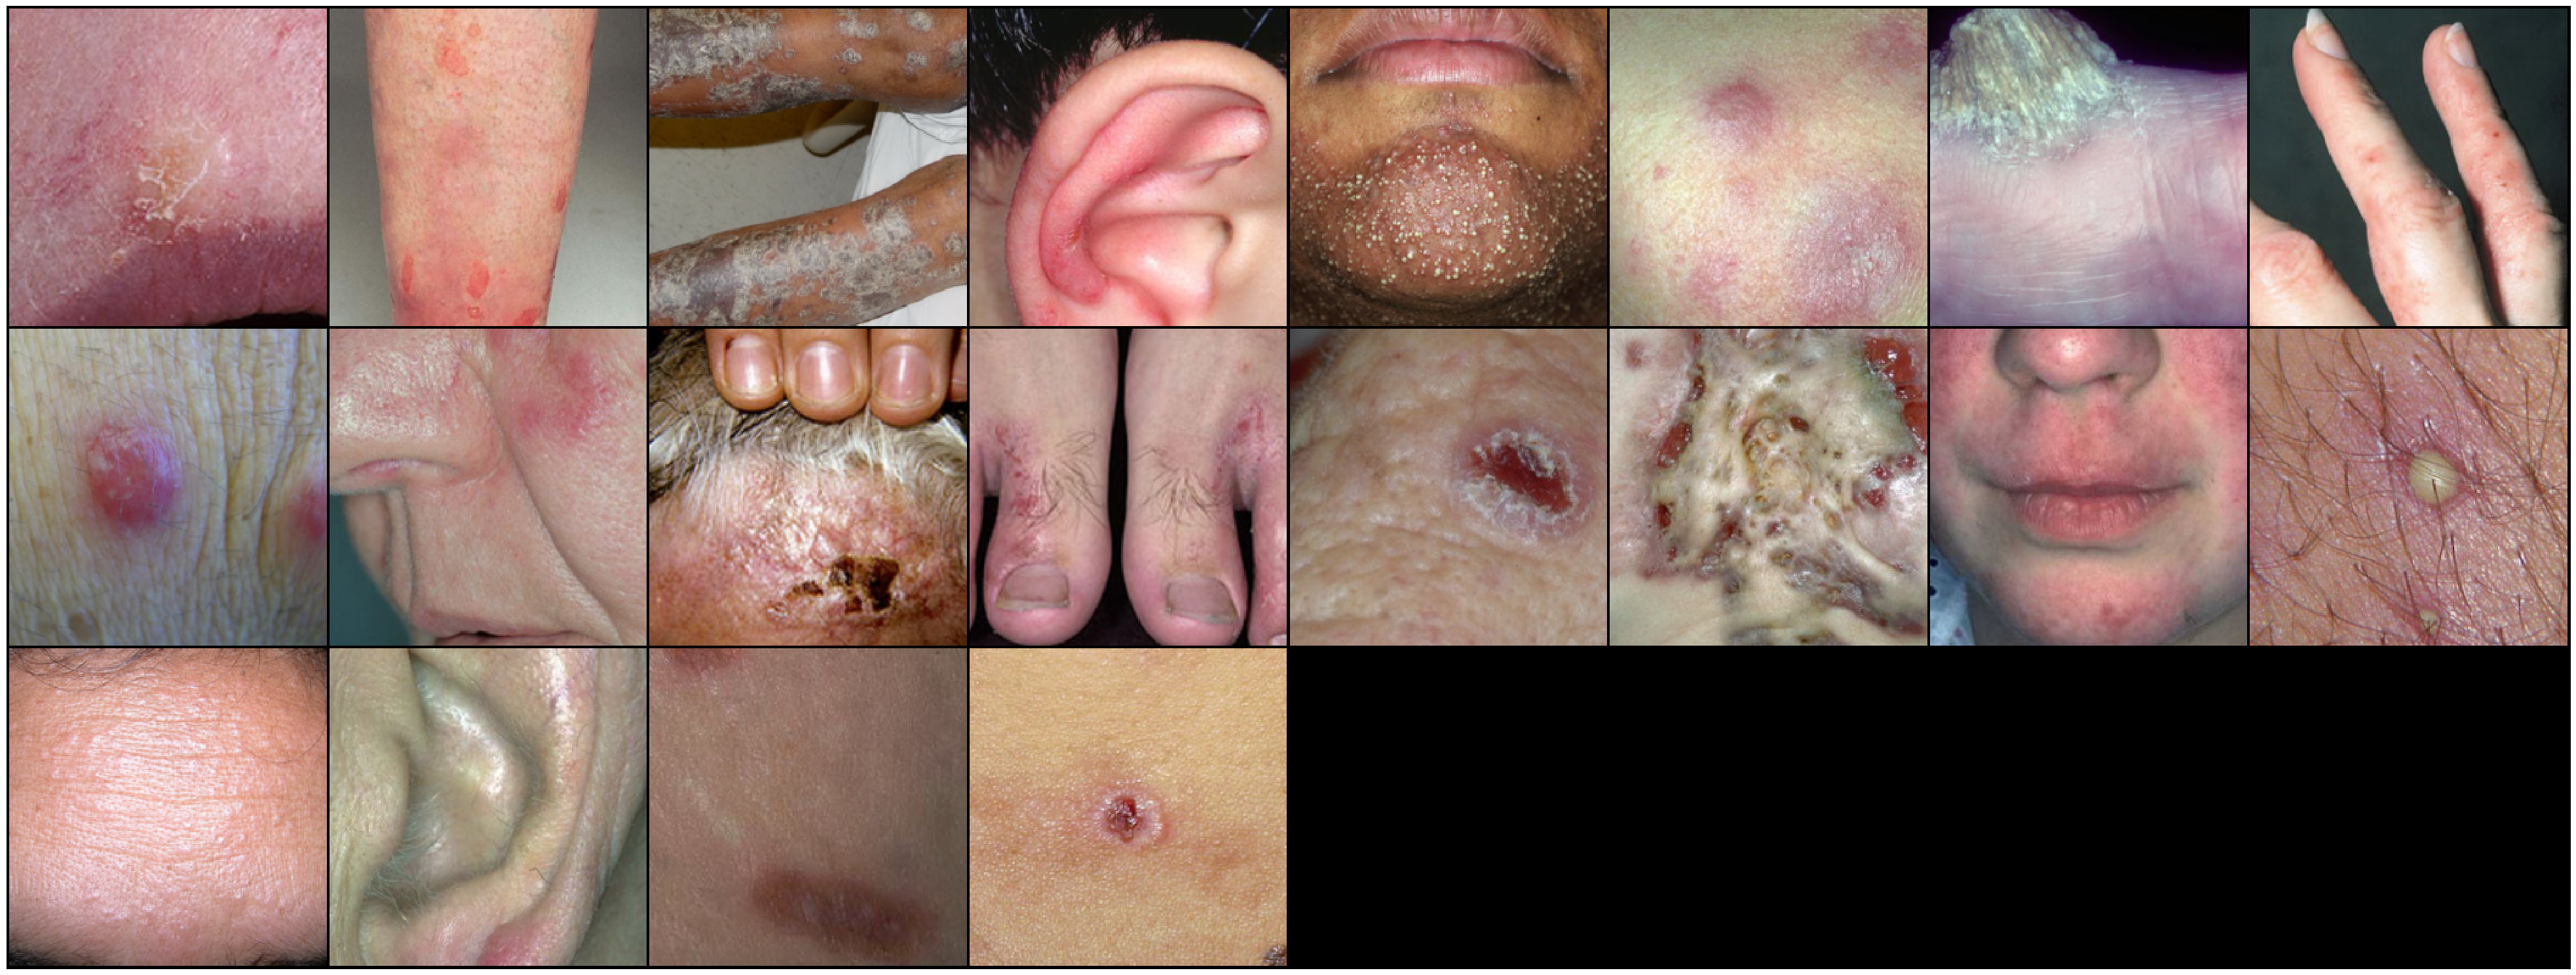

In [60]:
num_images = 20
explore_data, _ = torch.utils.data.random_split(validation_dataset, [num_images, 890-num_calib-num_images])

mosaiclist = []
sets = []
labels = class_names

for data in explore_data:
    img, label = data
    scores, set = cmodel(img.view(1,3,224,224).cuda())
    unnormalized_img = (img * torch.Tensor([0.229, 0.224, 0.225]).view(-1,1,1))+torch.Tensor([0.485, 0.456, 0.406]).view(-1,1,1)
  
    set = [class_names[s] for s in set[0]]
    sets = sets + [set]
    labels = labels + [class_names[label]]
    mosaiclist = mosaiclist + [unnormalized_img]

grid = torchvision.utils.make_grid(mosaiclist)

fig, ax = plt.subplots(figsize=(min(num_images,9)*5, np.floor(num_images/9+1)*5))
ax.imshow(grid.permute(1,2,0), interpolation='nearest')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()

for i in range(len(mosaiclist)):
    print(f"Image {i} has label \'{labels[i]}\', and the predictive set is {sets[i]}.")

# This is showing that our not-so-great model has offered the set of predictions for the medical practicioner to further descriminate the inferences

In [69]:
def get_labels(model, explore_data):
  mosaiclist = []
  sets = []
  labels = class_names

  for data in explore_data:
    img, label = data
    scores, set = model(img.view(1,3,224,224).cuda())
    unnormalized_img = (img * torch.Tensor([0.229, 0.224, 0.225]).view(-1,1,1))+torch.Tensor([0.485, 0.456, 0.406]).view(-1,1,1)
  
    set = [class_names[s] for s in set[0]]
    sets = sets + [set]
    labels = labels + [class_names[label]]
    mosaiclist = mosaiclist + [unnormalized_img]

  return mosaiclist, sets, labels


In [48]:
ALPHAS = [round(x, 2) for x in np.arange(0.05, 0.55, 0.05)]

In [49]:
#RAPS
K_REG = 0
LAMBDA = 1e-4

penalty = np.zeros((1, 10))
penalty[:, K_REG:] += LAMBDA

# randomized
RAND = True

# allow zero sets
ZERO = True  

def parse(values):
    ret = {}
    image = values['meta']['image']
    label = values['meta']['label']
    subgroup = values['meta']['subgroup']
    ret['image'] = image
    ret['label'] = label
    ret['subgroup'] = subgroup
    
    #  group mc by class
    class_pred = collections.defaultdict(list)
    for k, v in values.items():
        if k.startswith('mc_'):
            for i, x in enumerate(v[0]):
                class_pred[i].append(x)
                
    for c, pred in class_pred.items():
        ret[f'pred_{c}'] = pred
        
    return ret


In [50]:
def get_coverage(labels: list, prediction_sets: list) -> float:
    k = len(labels)
    assert k
    correct = 0
    for label, pred in zip(labels, prediction_sets):
        correct += 1 if label in pred else 0
    return correct / k

def get_cardinality(prediction_sets: list) -> float:
    k = len(prediction_sets)
    assert k
    return sum([len(x) for x in prediction_sets]) / k


In [70]:
cmodel_1 = ConformalModel(model, calib_loader, alpha=0.05, lamda_criterion='size')
cmodel_2 = ConformalModel(model, calib_loader, alpha=0.1, lamda_criterion='size')
cmodel_3 = ConformalModel(model, calib_loader, alpha=0.15, lamda_criterion='size')
cmodel_4 = ConformalModel(model, calib_loader, alpha=0.20, lamda_criterion='size')
cmodel_5 = ConformalModel(model, calib_loader, alpha=0.25, lamda_criterion='size')

mosaiclist_1, sets_1, labels_1 = get_labels(cmodel_1, explore_data)
mosaiclist_2, sets_2, labels_2 = get_labels(cmodel_2, explore_data)
mosaiclist_3, sets_3, labels_3 = get_labels(cmodel_3, explore_data)
mosaiclist_4, sets_4, labels_4 = get_labels(cmodel_4, explore_data)
mosaiclist_5, sets_5, labels_5 = get_labels(cmodel_5, explore_data)

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Optimal T=1.299961805343628
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Optimal T=1.299961805343628
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Optimal T=1.299961805343628
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Optimal T=1.299961805343628
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Optimal T=1.299961805343628


In [71]:
print(get_coverage(labels, sets))
print(get_coverage(labels_1, sets_1))
print(get_coverage(labels_2, sets_2))
print(get_coverage(labels_3, sets_3))
print(get_coverage(labels_4, sets_4))
print(get_coverage(labels_5, sets_5))


0.3333333333333333
0.3333333333333333
0.3
0.23333333333333334
0.23333333333333334
0.2


In [72]:
print(get_cardinality(sets_1))
print(get_cardinality(sets_2))
print(get_cardinality(sets_3))
print(get_cardinality(sets_4))
print(get_cardinality(sets_5))

5.95
5.35
4.75
4.35
2.65
